# 1. Setup

## 1-1. Library Setup

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Input
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2381128533377491833
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2523152133737570336
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [3]:
!nvidia-smi

Fri Dec 17 20:25:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    33W / 250W |    375MiB / 16280MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 1-2. parameter setup

In [5]:
basemodel = 'InceptionV3'
image_size = 128
image_channels = 3
batch_size = 64
num_epochs = 100
class_num = 7
None_patience_num = 30
imagenet_patience_num = 20
S_all_labels = "S0", "S1", "S2", "S3", "S4", "S5", "S6"
T_all_labels = "T0", "T1", "T2", "T3", "T4", "T5", "T6"

#base_path = ''
base_path = 'gdrive/My Drive/Research_7_2_1/'

path_data = base_path + 'data_numpy/'
path_model_result = base_path + 'model_result/1 - Base_model_result/' + basemodel + '/'

In [6]:
S_model_name_imagenet = 'S_' + basemodel + '_imagenet'
S_model_name_None = 'S_' + basemodel + '_None'
T_model_name_imagenet = 'T_' + basemodel + '_imagenet'
T_model_name_None = 'T_' + basemodel + '_None'

print(S_model_name_None, S_model_name_imagenet, T_model_name_None, T_model_name_imagenet)

basemodel_list=[S_model_name_imagenet, S_model_name_None, T_model_name_imagenet, T_model_name_None]
basemodel_list

S_InceptionV3_None S_InceptionV3_imagenet T_InceptionV3_None T_InceptionV3_imagenet


['S_InceptionV3_imagenet',
 'S_InceptionV3_None',
 'T_InceptionV3_imagenet',
 'T_InceptionV3_None']

In [7]:
def createDirectory(name): 
    try: 
        if not os.path.exists(name): 
            os.makedirs(path_model_result + name) 
    except OSError: 
        print("Error: Failed to create the directory.")  
        
for i in basemodel_list:
    createDirectory(i)

# 2. Data Load and Image Check

## 2-1. Data Load

In [8]:
xTrain_S = np.load(path_data + 'xTrain_S.npy')
xValid_S = np.load(path_data + 'xValid_S.npy')
xTest_S = np.load(path_data + 'xTest_S.npy')

yTrain_S = np.load(path_data + 'yTrain_S.npy')
yValid_S = np.load(path_data + 'yValid_S.npy')
yTest_S = np.load(path_data + 'yTest_S.npy')

xTrain_T = np.load(path_data + 'xTrain_T.npy')
xValid_T = np.load(path_data + 'xValid_T.npy')
xTest_T = np.load(path_data + 'xTest_T.npy')

yTrain_T = np.load(path_data + 'yTrain_T.npy')
yValid_T = np.load(path_data + 'yValid_T.npy')
yTest_T = np.load(path_data + 'yTest_T.npy')

In [9]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(2358, 128, 128, 3) (2358, 1)
(786, 128, 128, 3) (786, 1)
(786, 128, 128, 3) (786, 1)

(2598, 128, 128, 3) (2598, 1)
(866, 128, 128, 3) (866, 1)
(866, 128, 128, 3) (866, 1)


In [10]:
xTrain_S = xTrain_S.astype('float32')/255
xValid_S = xValid_S.astype('float32')/255
xTest_S = xTest_S.astype('float32')/255

yTrain_S = np_utils.to_categorical(yTrain_S, class_num)
yValid_S = np_utils.to_categorical(yValid_S, class_num)
yTest_S = np_utils.to_categorical(yTest_S, class_num)

xTrain_T = xTrain_T.astype('float32')/255
xValid_T = xValid_T.astype('float32')/255
xTest_T = xTest_T.astype('float32')/255

yTrain_T = np_utils.to_categorical(yTrain_T, class_num)
yValid_T = np_utils.to_categorical(yValid_T, class_num)
yTest_T = np_utils.to_categorical(yTest_T, class_num)

In [11]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(2358, 128, 128, 3) (2358, 7)
(786, 128, 128, 3) (786, 7)
(786, 128, 128, 3) (786, 7)

(2598, 128, 128, 3) (2598, 7)
(866, 128, 128, 3) (866, 7)
(866, 128, 128, 3) (866, 7)


## 2-2. Image Check

xTrain_S image Numbers :  2358
xTrain_S image Numbers // 10 :  235
11


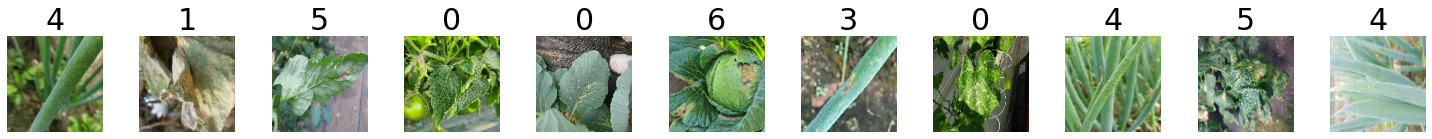

In [12]:
temp_S_a = len(xTrain_S)
print("xTrain_S image Numbers : ", temp_S_a)
temp_S_b = temp_S_a//10
print("xTrain_S image Numbers // 10 : ", temp_S_b)
temp_S_c = 0
for i in range(0, temp_S_a, temp_S_b):
    temp_S_c += 1
print(temp_S_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0, temp_S_a, temp_S_b):
    plt.subplot(1, temp_S_c, c+1)
    plt.imshow(xTrain_S[i])
    plt.title(yTrain_S[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

xTrain_S image Numbers :  2598
xTrain_S image Numbers // 10 :  259
11


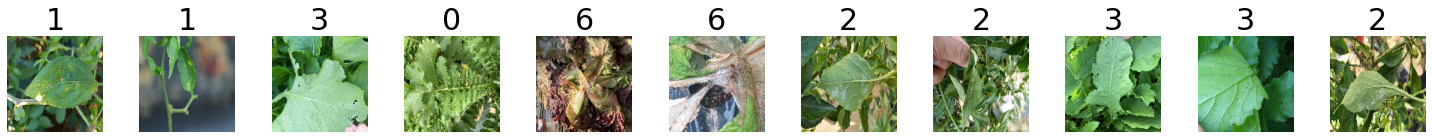

In [13]:
temp_T_a = len(xTrain_T)
print("xTrain_S image Numbers : ", temp_T_a)
temp_T_b = temp_T_a//10
print("xTrain_S image Numbers // 10 : ", temp_T_b)
temp_T_c = 0
for i in range(0, temp_T_a, temp_T_b):
    temp_T_c += 1
print(temp_T_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0,temp_T_a,temp_T_b):
    plt.subplot(1, temp_T_c, c+1)
    plt.imshow(xTrain_T[i])
    plt.title(yTrain_T[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

# 3. Network Setting and Training

## 3-1. Network Setting

In [14]:
def feature_extractor_None(inp):
    base_model=tf.keras.applications.InceptionV3 (
                include_top=False, weights=None, input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_None(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_None():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_None(inp)
    classifier_output = classifier_None(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [15]:
def feature_extractor_imagenet(inp):
    base_model=tf.keras.applications.InceptionV3 (
                include_top=False, weights='imagenet', input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_imagenet(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_imagenet():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_imagenet(inp)
    classifier_output = classifier_imagenet(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [16]:
#plot_model(model_None())
#plot_model(model_imagenet())

## 3-2. Source Domain Training - weights=None

In [17]:
S_basemodel_None=model_None()
#S_basemodel_None.summary()

In [18]:
S_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

S_basemodel_None_main =S_basemodel_None.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
37/37 [==============================] - 22s 192ms/step - loss: 1.3126 - accuracy: 0.5360 - val_loss: 2.0860 - val_accuracy: 0.1272
Epoch 2/100
37/37 [==============================] - 4s 119ms/step - loss: 0.8035 - accuracy: 0.7256 - val_loss: 2.8473 - val_accuracy: 0.1272
Epoch 3/100
37/37 [==============================] - 4s 119ms/step - loss: 0.6185 - accuracy: 0.7939 - val_loss: 2.9533 - val_accuracy: 0.1196
Epoch 4/100
37/37 [==============================] - 4s 119ms/step - loss: 0.5196 - accuracy: 0.8287 - val_loss: 6.0924 - val_accuracy: 0.1196
Epoch 5/100
37/37 [==============================] - 5s 123ms/step - loss: 0.4074 - accuracy: 0.8643 - val_loss: 3.1918 - val_accuracy: 0.2137
Epoch 6/100
37/37 [==============================] - 5s 127ms/step - loss: 0.4323 - accuracy: 0.8588 - val_loss: 7.3626 - val_accuracy: 0.1234
Epoch 7/100
37/37 [==============================] - 4s 122ms/step - loss: 0.3197 - accuracy: 0.8876 - val_loss: 9.2420 - val_accuracy: 0.056

In [19]:
S_basemodel_None_df = pd.DataFrame(S_basemodel_None_main.history)
S_basemodel_None_df.to_csv( path_model_result + S_model_name_None + '/' + S_model_name_None + '_df.csv' )
S_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,1.312584,0.536048,2.086014,0.127226
1,0.803480,0.725615,2.847322,0.127226
2,0.618540,0.793893,2.953258,0.119593
3,0.519649,0.828668,6.092378,0.119593
4,0.407395,0.864292,3.191850,0.213740
...,...,...,...,...
95,0.073331,0.980492,12.133058,0.637405
96,0.042220,0.987277,0.819964,0.843511
97,0.029720,0.994487,0.460413,0.894402
98,0.026705,0.993639,0.566513,0.867684


Minimum validation loss: 0.3197023570537567
Maximum validation accuracy: 0.9325699806213379


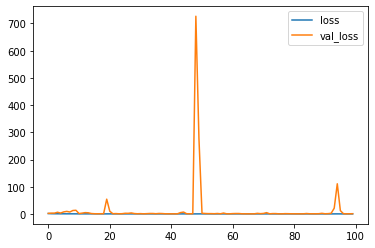

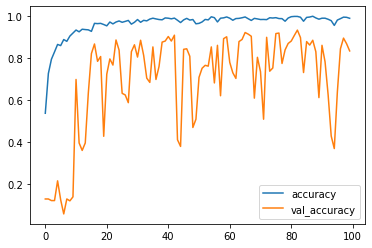

In [20]:
S_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_loss,val_loss.png')
S_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_None_df['val_accuracy'].max()))

In [21]:
print("Evaluate on test data")
S_basemodel_None_results = S_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_basemodel_None_results)

Evaluate on test data
25/25 [==============================] - 1s 28ms/step - loss: 1.0290 - accuracy: 0.8117
test loss, test acc: [1.0290144681930542, 0.8117048144340515]


In [22]:
S_basemodel_None_pred_Y = S_basemodel_None.predict(xTest_S, verbose = True)

25/25 [==============================] - 2s 23ms/step


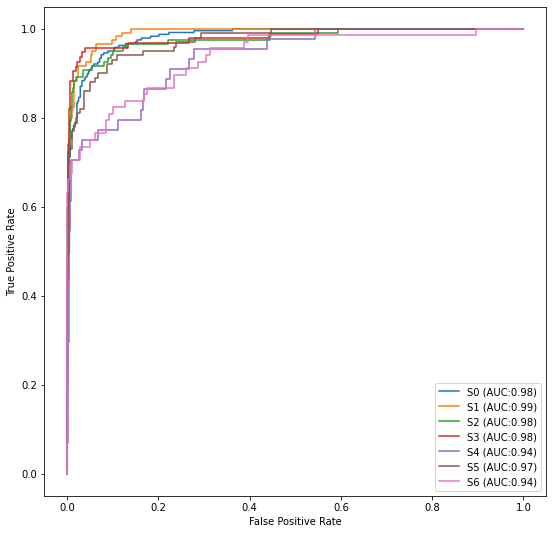

In [23]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_None + '/' + S_model_name_None +'_TESTSET_AUC.png' )

## 3-3. Source Domain Training - weights='imagenet'

In [24]:
S_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

87924736/87910968 [==============================] - 1s 0us/step


In [25]:
S_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

S_basemodel_imagenet_main =S_basemodel_imagenet.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
37/37 [==============================] - 12s 160ms/step - loss: 0.8128 - accuracy: 0.7349 - val_loss: 11.5584 - val_accuracy: 0.2277
Epoch 2/100
37/37 [==============================] - 5s 122ms/step - loss: 0.2744 - accuracy: 0.9084 - val_loss: 4.9634 - val_accuracy: 0.6590
Epoch 3/100
37/37 [==============================] - 4s 119ms/step - loss: 0.1959 - accuracy: 0.9360 - val_loss: 1.9444 - val_accuracy: 0.6412
Epoch 4/100
37/37 [==============================] - 5s 122ms/step - loss: 0.1468 - accuracy: 0.9580 - val_loss: 2.2523 - val_accuracy: 0.6934
Epoch 5/100
37/37 [==============================] - 4s 122ms/step - loss: 0.1765 - accuracy: 0.9487 - val_loss: 0.7225 - val_accuracy: 0.8333
Epoch 6/100
37/37 [==============================] - 4s 119ms/step - loss: 0.0974 - accuracy: 0.9784 - val_loss: 2.3564 - val_accuracy: 0.6247
Epoch 7/100
37/37 [==============================] - 4s 119ms/step - loss: 0.1374 - accuracy: 0.9665 - val_loss: 2.3969 - val_accuracy: 0.70

In [26]:
S_basemodel_imagenet_df = pd.DataFrame(S_basemodel_imagenet_main.history)
S_basemodel_imagenet_df.to_csv( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_df.csv' )
S_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.812809,0.734945,11.558354,0.227735
1,0.274386,0.908397,4.963441,0.659033
2,0.195936,0.935963,1.944391,0.641221
3,0.146783,0.958015,2.252279,0.693384
4,0.176472,0.948685,0.722462,0.833333
...,...,...,...,...
65,0.012922,0.995335,0.531305,0.886768
66,0.017465,0.994911,0.883638,0.825700
67,0.010698,0.997031,0.335791,0.924936
68,0.011185,0.997455,0.206750,0.952926


Minimum validation loss: 0.0907510444521904
Maximum validation accuracy: 0.9783715009689331


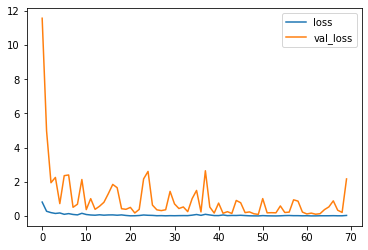

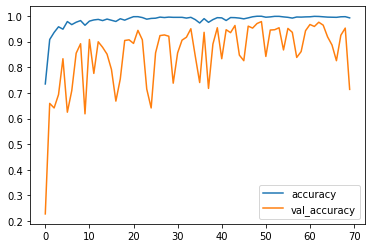

In [27]:
S_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_loss,val_loss.png')
S_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_imagenet_df['val_accuracy'].max()))

In [28]:
print("Evaluate on test data")
S_model_name_imagenet_results = S_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_model_name_imagenet_results)

Evaluate on test data
25/25 [==============================] - 1s 28ms/step - loss: 0.2211 - accuracy: 0.9542
test loss, test acc: [0.2210925668478012, 0.9541984796524048]


In [29]:
S_model_name_imagenet_pred_Y = S_basemodel_imagenet.predict(xTest_S, verbose = True)

25/25 [==============================] - 2s 23ms/step


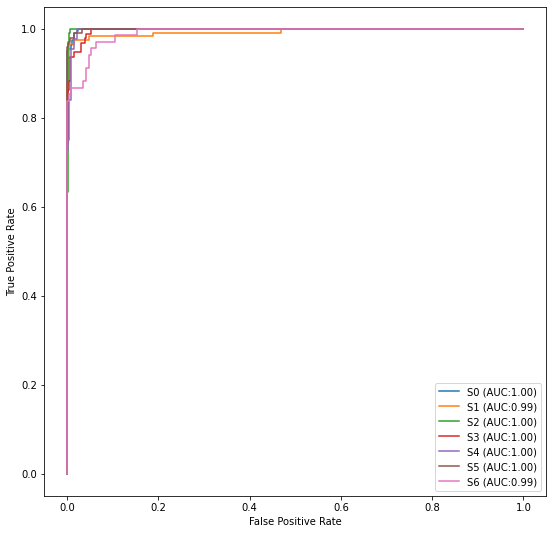

In [30]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet +'_TESTSET_AUC.png' )

## 3-4. Target Domain Training - weights=None

In [31]:
T_basemodel_None=model_None()
#S_basemodel_None.summary()

In [32]:
T_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

T_basemodel_None_main =T_basemodel_None.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
41/41 [==============================] - 14s 180ms/step - loss: 1.3890 - accuracy: 0.4865 - val_loss: 1.9595 - val_accuracy: 0.1085
Epoch 2/100
41/41 [==============================] - 5s 122ms/step - loss: 0.9604 - accuracy: 0.6644 - val_loss: 4.6489 - val_accuracy: 0.1155
Epoch 3/100
41/41 [==============================] - 5s 118ms/step - loss: 0.7632 - accuracy: 0.7433 - val_loss: 6.0446 - val_accuracy: 0.1085
Epoch 4/100
41/41 [==============================] - 5s 121ms/step - loss: 0.7212 - accuracy: 0.7513 - val_loss: 2.8686 - val_accuracy: 0.2390
Epoch 5/100
41/41 [==============================] - 5s 118ms/step - loss: 0.6629 - accuracy: 0.7871 - val_loss: 5.2687 - val_accuracy: 0.1085
Epoch 6/100
41/41 [==============================] - 5s 118ms/step - loss: 0.7445 - accuracy: 0.7710 - val_loss: 4.2212 - val_accuracy: 0.2194
Epoch 7/100
41/41 [==============================] - 5s 118ms/step - loss: 0.6413 - accuracy: 0.7852 - val_loss: 6.1931 - val_accuracy: 0.189

In [33]:
T_basemodel_None_df = pd.DataFrame(T_basemodel_None_main.history)
T_basemodel_None_df.to_csv( path_model_result + T_model_name_None + '/' + T_model_name_None + '_df.csv' )
T_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,1.388970,0.486528,1.959534,0.108545
1,0.960434,0.664357,4.648855,0.115473
2,0.763160,0.743264,6.044552,0.108545
3,0.721233,0.751347,2.868565,0.239030
4,0.662918,0.787144,5.268700,0.108545
...,...,...,...,...
95,0.017541,0.993841,2.279285,0.647806
96,0.071025,0.979985,1.277696,0.756351
97,0.049086,0.983834,1.128211,0.795612
98,0.033165,0.989222,1.264359,0.792148


Minimum validation loss: 0.5088711977005005
Maximum validation accuracy: 0.8787528872489929


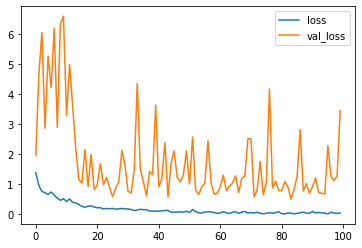

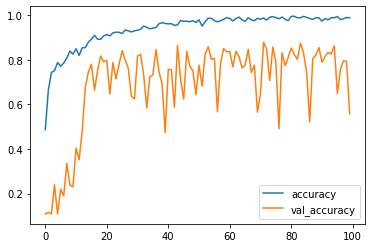

In [34]:
T_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_loss,val_loss.png')
T_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_None_df['val_accuracy'].max()))

In [35]:
print("Evaluate on test data")
T_basemodel_None_results = T_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_basemodel_None_results)

Evaluate on test data
28/28 [==============================] - 1s 34ms/step - loss: 3.6615 - accuracy: 0.5323
test loss, test acc: [3.6615166664123535, 0.5323325395584106]


In [36]:
T_basemodel_None_pred_Y = T_basemodel_None.predict(xTest_T, verbose = True)

28/28 [==============================] - 2s 24ms/step


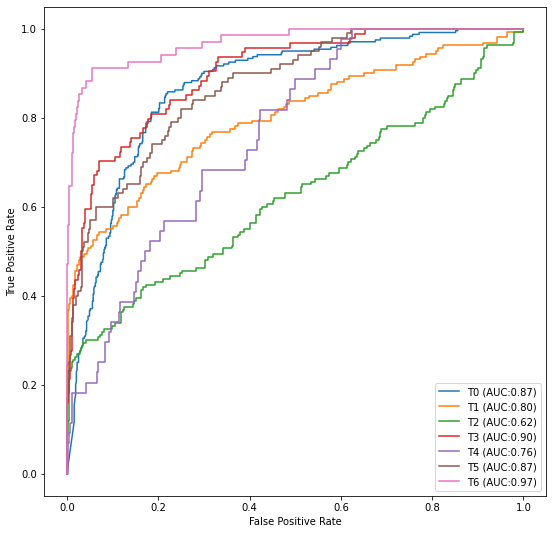

In [37]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_None + '/' + T_model_name_None + '_TESTSET_AUC.png' )

## 3-5. Target Domain Training - weights='imagenet'

In [38]:
T_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

In [39]:
T_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

T_basemodel_imagenet_main =T_basemodel_imagenet.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
41/41 [==============================] - 13s 156ms/step - loss: 0.9268 - accuracy: 0.6824 - val_loss: 33.7057 - val_accuracy: 0.2771
Epoch 2/100
41/41 [==============================] - 5s 121ms/step - loss: 0.3318 - accuracy: 0.8861 - val_loss: 4.7269 - val_accuracy: 0.4550
Epoch 3/100
41/41 [==============================] - 5s 122ms/step - loss: 0.2807 - accuracy: 0.9049 - val_loss: 1.7319 - val_accuracy: 0.6374
Epoch 4/100
41/41 [==============================] - 5s 122ms/step - loss: 0.2104 - accuracy: 0.9338 - val_loss: 1.2526 - val_accuracy: 0.6594
Epoch 5/100
41/41 [==============================] - 5s 121ms/step - loss: 0.1711 - accuracy: 0.9465 - val_loss: 1.5236 - val_accuracy: 0.7182
Epoch 6/100
41/41 [==============================] - 5s 122ms/step - loss: 0.1173 - accuracy: 0.9634 - val_loss: 1.7400 - val_accuracy: 0.7714
Epoch 7/100
41/41 [==============================] - 5s 121ms/step - loss: 0.1247 - accuracy: 0.9654 - val_loss: 1.0307 - val_accuracy: 0.79

In [40]:
T_basemodel_imagenet_df = pd.DataFrame(T_basemodel_imagenet_main.history)
T_basemodel_imagenet_df.to_csv( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_df.csv' )
T_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.926803,0.682448,33.705711,0.277136
1,0.331756,0.886066,4.726872,0.454965
2,0.280676,0.904927,1.731910,0.637413
3,0.210376,0.933795,1.252610,0.659353
4,0.171143,0.946497,1.523647,0.718245
5,0.117253,0.963433,1.739994,0.771363
6,0.124721,0.965358,1.030654,0.792148
7,0.104308,0.965358,1.262113,0.744804
8,0.141405,0.954196,0.941746,0.802540
9,0.122845,0.960354,1.388699,0.688222


Minimum validation loss: 0.3027585744857788
Maximum validation accuracy: 0.923787534236908


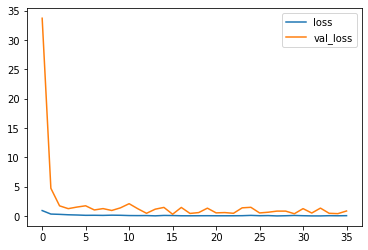

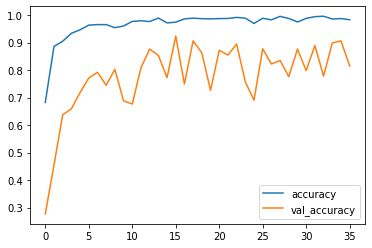

In [41]:
T_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_loss,val_loss.png')
T_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_imagenet_df['val_accuracy'].max()))

In [42]:
print("Evaluate on test data")
T_model_name_imagenet_results = T_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_model_name_imagenet_results)

Evaluate on test data
28/28 [==============================] - 1s 28ms/step - loss: 0.3946 - accuracy: 0.9065
test loss, test acc: [0.39461570978164673, 0.9064664840698242]


In [43]:
T_model_name_imagenet_pred_Y = T_basemodel_imagenet.predict(xTest_T, verbose = True)

28/28 [==============================] - 2s 24ms/step


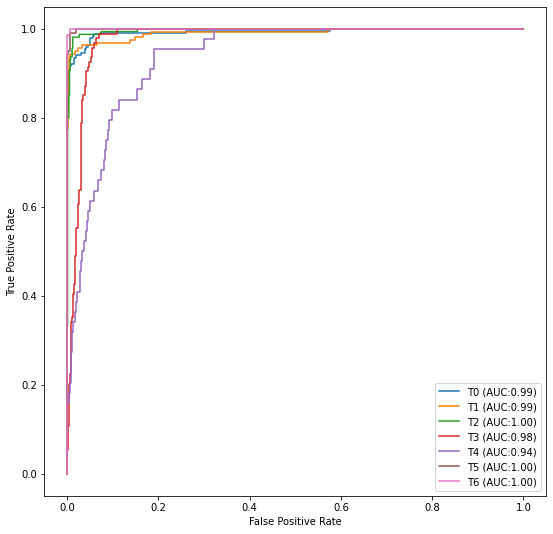

In [44]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_TESTSET_AUC.png' )

# 4. Result Report

In [45]:
print(S_model_name_None)
print("test loss, test acc:", S_basemodel_None_results)

S_InceptionV3_None
test loss, test acc: [1.0290144681930542, 0.8117048144340515]


In [46]:
print(S_model_name_imagenet)
print("test loss, test acc:", S_model_name_imagenet_results)

S_InceptionV3_imagenet
test loss, test acc: [0.2210925668478012, 0.9541984796524048]


In [47]:
print(T_model_name_None)
print("test loss, test acc:", T_basemodel_None_results)

T_InceptionV3_None
test loss, test acc: [3.6615166664123535, 0.5323325395584106]


In [48]:
print(T_model_name_imagenet)
print("test loss, test acc:", T_model_name_imagenet_results)

T_InceptionV3_imagenet
test loss, test acc: [0.39461570978164673, 0.9064664840698242]


# 5. Source Domain Training Model ↔ Target Domain Training Model 상호 Test Data Set 평가 

In [49]:
print( S_model_name_None + " →→→ Target Test")
S_basemodel_None_results_T = S_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_basemodel_None_results_T)

S_InceptionV3_None →→→ Target Test
28/28 [==============================] - 1s 28ms/step - loss: 5.8215 - accuracy: 0.1940
test loss, test acc: [5.821457862854004, 0.1939953863620758]


In [50]:
print( S_model_name_imagenet + " →→→ Target Test")
S_model_name_imagenet_results_T = S_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_model_name_imagenet_results_T)

S_InceptionV3_imagenet →→→ Target Test
28/28 [==============================] - 1s 28ms/step - loss: 4.8636 - accuracy: 0.2217
test loss, test acc: [4.863584041595459, 0.2217090129852295]


In [51]:
print( T_model_name_None + " →→→ Source Test")
T_basemodel_None_results_S = T_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_basemodel_None_results_S)

T_InceptionV3_None →→→ Source Test
25/25 [==============================] - 1s 28ms/step - loss: 5.2877 - accuracy: 0.2188
test loss, test acc: [5.287702560424805, 0.21882951259613037]


In [52]:
print( T_model_name_imagenet + " →→→ Source Test")
T_model_name_imagenet_results_S = T_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_model_name_imagenet_results_S)

T_InceptionV3_imagenet →→→ Source Test
25/25 [==============================] - 1s 27ms/step - loss: 4.3581 - accuracy: 0.2379
test loss, test acc: [4.358133792877197, 0.23791348934173584]


# 6. Model Save 

In [53]:
S_basemodel_None.save( path_model_result + S_model_name_None + '/' + S_model_name_None + '.h5' )
S_basemodel_imagenet.save( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '.h5' )
T_basemodel_None.save( path_model_result + T_model_name_None + '/' + T_model_name_None + '.h5' )
T_basemodel_imagenet.save( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '.h5' )